# References used for dataset <br>
1. http://cs231n.stanford.edu/tiny-imagenet-200.zip
2. https://github.com/seshuad/IMagenet

# References used for network architecture
1. https://arxiv.org/abs/1704.06904
2. https://github.com/tengshaofeng/ResidualAttentionNetwork-pytorch/blob/master/Residual-Attention-Network/model/attention_module.py
3. https://github.com/Piyushdharkar/Residual-Attention-Aware-Network
4. https://github.com/deontaepharr/Residual-Attention-Network

# References used for keras functions
1. https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 
2. https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [ ]:
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

**Load the tiny ImageNet Dataset**

In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

In [ ]:
!pip install scipy==1.1.0

In [ ]:
import scipy
scipy.__version__

'1.1.0'

In [ ]:
import time
import scipy.ndimage as nd
import numpy as np

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [nd.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(nd.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


finished loading data, in 77.47798323631287 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [ ]:
x_train = train_data
y_train = train_labels
x_test = test_data
y_test = test_labels

In [ ]:
print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (100000, 64, 64, 3)

 y_train.shape:  (100000, 200)

 x_test.shape:  (10000, 64, 64, 3)

 y_test.shape:  (10000, 200)


**Visualize the dataset**

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 200)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 200)

**Divide the data into train, test and validation**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(0)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.8)

print("\n x_train.shape: ", x_train.shape)
print("\n y_train.shape: ", y_train.shape)

print("\n x_val.shape: ", x_val.shape)
print("\n y_val.shape: ", y_val.shape)

print("\n x_test.shape: ", x_test.shape)
print("\n y_test.shape: ", y_test.shape)


 x_train.shape:  (80000, 64, 64, 3)

 y_train.shape:  (80000, 200)

 x_val.shape:  (20000, 64, 64, 3)

 y_val.shape:  (20000, 200)

 x_test.shape:  (10000, 64, 64, 3)

 y_test.shape:  (10000, 200)


**Creating Residual Block**

In [ ]:
from tensorflow.keras import activations

In [ ]:
def create_residual_block(val_in, filter_in, filter_out):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @output : Tensor created after residual block
    '''
    
    # Repeat BN=>ReLU=>Conv2D pattern three times
    
    x = tf.keras.layers.BatchNormalization()(val_in)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_in, kernel_size = 1, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 3, padding = 'same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(x)
    
    val_in = tf.keras.layers.Conv2D(filters = filter_out, kernel_size = 1, padding = 'same')(val_in)
    
    x = tf.keras.layers.Add()([val_in, x])
    
    return x

**Creating Attention Block**

The attention Module consists of mask branch and trunk branch. The trunk branch performs feature selection (using the residual blocks) and the mask branch learns the mask to be applied from downsampling and upsampling. The output of the attention block is (1+M(x)).T(x), where M(x) is the mask and T(x) is the output of the trunk branch (pre-processing).

In [ ]:
def create_attention_block(val_in, filter_in, filter_out, p = 1, t = 2, r = 1):
    '''
    @params val_in : Input shape
    @params filter_in : Input filter
    @params filter_out : Output filter
    @params p : Number of pre-processing residual units before splitting into trunk and mask branch (is also a hyperparameter)
    @params t : Number of residual units in trunk branch (is also a hyperparameter)
    @params r : Number of residual units between adjacent pooling layer in the mask branch (is also a hyperparameter)
    @output: Tensor created after attention block
    '''
    
    # Creating residual blocks for pre-processing residual units
    for units in range(p):
        val_in = create_residual_block(val_in, filter_in, filter_out)
     
    val_out_trunk = val_in
    
    # Feature Processing for the trunk branch. Input to the trunk branch is the output of the pre-processing residual blocks
    for units in range(t):
        val_out_trunk = create_residual_block(val_out_trunk, filter_in, filter_out)
        
    # 1. Downsample using MaxPool2D
    # 2. 'r' represents the number of residual units between two max pool layers in the mask branch. Implemented using for loop
    # 3. Add skip connection
    # 4. Upsample using UpSampling2D
    
    
    # Down Sampling One
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(val_in)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    
    # Adding Skip Connection
    skip_connection = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Down Sampling Two
    soft_mask_output = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(soft_mask_output)
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    
    # Up Sampling One
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
        soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
        soft_mask_output = tf.keras.layers.Add()([soft_mask_output, skip_connection])
        
    # Up Sampling Two
    for units in range(r):
        soft_mask_output = create_residual_block(soft_mask_output, filter_in, filter_out)
    soft_mask_output = tf.keras.layers.UpSampling2D(size=2)(soft_mask_output)
    
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Conv2D(filter_in, kernel_size=1)(soft_mask_output)
    soft_mask_output = tf.keras.layers.Activation(activation='sigmoid')(soft_mask_output)
    
    # Output is (1 + M(x))*T(x)
    output = tf.keras.layers.Lambda(lambda x: x + 1)(soft_mask_output)
    output = tf.keras.layers.Multiply()([output, val_out_trunk]) 
    
    for i in range(p):
        output = create_residual_block(output, filter_in, filter_out)

    return output

**Creating the Model**

In [ ]:
def create_model(size, classes):
    '''
    @params size : Input tensor siz
    @params classes : Number of output classes
    @output : Returns the model created by attention modules
    '''
    val_in = tf.keras.layers.Input(shape=size)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same')(val_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    x = create_residual_block(val_in=x, filter_in=32, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=32, filter_out=32)

    x = create_residual_block(val_in=x, filter_in=64, filter_out=128)
    x = create_attention_block(val_in=x, filter_in=64, filter_out=64)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_attention_block(val_in=x, filter_in=128, filter_out=128)

    x = create_residual_block(val_in=x, filter_in=128, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)
    x = create_residual_block(val_in=x, filter_in=256, filter_out=256)

    x = tf.keras.layers.AveragePooling2D(pool_size=4)(x)
    x = tf.keras.layers.Flatten()(x)

    output = tf.keras.layers.Dense(classes, activation='softmax')(x)


    return tf.keras.models.Model(val_in, output)

**Initialize the Model**

In [ ]:
model_imagenet = create_model(x_train.shape[1:], 200)

model_imagenet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Viusalize the Model**

To visualize the model, we use the Netron Package

1. Install netron using the pip command below

2. Download Netron package from here : https://github.com/lutzroeder/netron/releases/tag/v5.4.3

3. Save the model using the command below

4. Open and visualize the saved model with Netron

**Train the Model**

In [ ]:
def lr_schedule (epoch, lr):
    if epoch == 100:
        lr = 0.1 * lr
        print("\n Reducing learning by factor of 10 at epoch: ", epoch)
    elif epoch == 150:
        lr = 0.1 * lr
        print("\n Reducing learning by factor of 10 at epoch: ", epoch)
    
    return lr

In [ ]:
augmented_data_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2, vertical_flip=True, 
                                                           rotation_range=0.15, width_shift_range=0.15, height_shift_range=0.15,
                                                           zoom_range=0.15)

augmented_data_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

flow_data_train = augmented_data_train.flow(x_train, y_train)

flow_data_val = augmented_data_val.flow(x_val, y_val)

In [ ]:
tic = time.time()

#callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history_imagenet = model_imagenet.fit(flow_data_train, validation_data=flow_data_val, batch_size=1024, 
                                        steps_per_epoch=flow_data_train.n // 1024, validation_steps=flow_data_val.n // 1024, epochs = 400)

toc = time.time()

Epoch 1/400
78/78 [==============================] - 22s 283ms/step - loss: 7.0508 - accuracy: 0.0204 - val_loss: 5.7408 - val_accuracy: 0.0139
Epoch 2/400
78/78 [==============================] - 22s 283ms/step - loss: 7.1826 - accuracy: 0.0168 - val_loss: 5.8939 - val_accuracy: 0.0104
Epoch 3/400
78/78 [==============================] - 22s 283ms/step - loss: 7.2539 - accuracy: 0.0164 - val_loss: 9.3347 - val_accuracy: 0.0104
Epoch 4/400
78/78 [==============================] - 22s 282ms/step - loss: 6.6585 - accuracy: 0.0164 - val_loss: 6.0995 - val_accuracy: 0.0104
Epoch 5/400
78/78 [==============================] - 22s 283ms/step - loss: 6.0534 - accuracy: 0.0216 - val_loss: 5.6366 - val_accuracy: 0.0208
Epoch 6/400
78/78 [==============================] - 22s 283ms/step - loss: 5.8584 - accuracy: 0.0228 - val_loss: 5.4566 - val_accuracy: 0.0174
Epoch 7/400
78/78 [==============================] - 22s 283ms/step - loss: 5.8599 - accuracy: 0.0240 - val_loss: 6.0863 - val_accuracy:

In [ ]:
print("\n Time to train ImageNet: ", (toc - tic)/60, "mins")


 Time to train ImageNet:  146.39513926506044 mins


Text(0.5, 1.0, 'Loss vs Epochs')

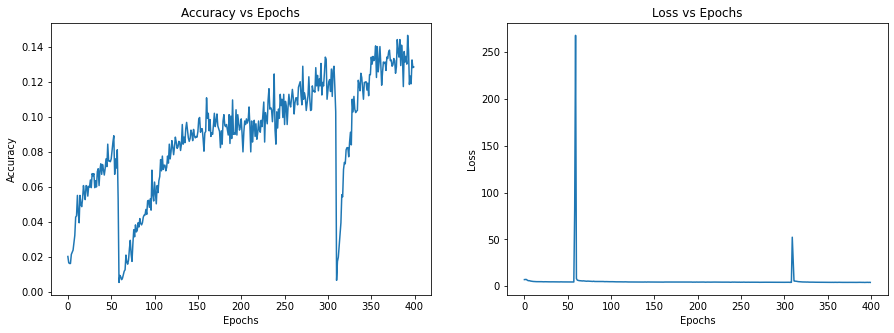

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

axes[0].plot(history_imagenet.history['accuracy'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Accuracy vs Epochs")

axes[1].plot(history_imagenet.history['loss'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title("Loss vs Epochs")

In [ ]:
model_imagenet.save('model_imagenet.h5')

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
